In [1]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
import tensorflow as tf
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input, Concatenate, BatchNormalization, LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Descargar la lista de stopwords si no está ya descargada
nltk.download('stopwords')

# Cargar las stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lingf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = Loader.load_train()

c:\Users\lingf\OneDrive\Escritorio\SRC\Cars_Price_Prediction-1\NLP\..\utils\loader.py:133: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\lingf\OneDrive\Escritorio\SRC\Cars_Price_Prediction-1\NLP\..\utils\loader.py:133: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\lingf\OneDrive\Escritorio\SRC\Cars_Price_Prediction-1\NLP\..\utils\loader.py:133: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\lingf\OneDrive\Escritorio\SRC\Cars_Price_Prediction-1\NLP\..\utils\loader.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on

In [3]:
descriptions = [col for col in train.columns if "description" in col]

print(descriptions)

def custom_concat(row, cols):
    # Construir la descripción con lógica condicional basada en el valor de la celda
    parts = []
    for col_name in cols:  # Cambio para iterar solo sobre las columnas especificadas
        if col_name in row.index:  # Verificar que el nombre de la columna esté en el DataFrame
            value = row[col_name]
            if value == "no tiene" or not isinstance(value, str):
                parts.append(f"no tiene {col_name}")
            else:
                parts.append(str(value))  # Convertir a string para evitar problemas al unir
    # Unir todas las partes con espacios
    return ' '.join(parts)

# Aplicar la función al DataFrame
train['full_description'] = train.apply(custom_concat, axis=1, args=(descriptions,))
#train[descriptions].apply(lambda col: col.apply(lambda x: type(x).__name__).value_counts())

#descriptions.append("idx")
#descriptions.append("price")
#descriptions.append("km")

['motor_description', 'transmission_description', 'parking_sensors_description', 'Exterior_Llantas_description', 'Exterior_Molduras_description', 'Exterior_Neumáticos_description', 'Exterior_Puerta_description', 'Exterior_Retrovisor_description', 'Confort_Volante_description', 'seat_description', 'head_supporter_description']


In [4]:
filtered_columns = ["price", "km", "fuelType", "full_description"]
train = train[filtered_columns]
train["price_per_kilometer"] = train["price"]/train["km"]
train.dropna(inplace=True)
train

,price,km,fuelType,full_description,price_per_kilometer
idx,,,,,
105953,-0.077067,-0.219436,Gasolina,"Motor de 1,3 litros ( 1.332 cc ) , cuatro cili...",0.351204
15683,-0.193101,0.362457,Diésel,"Motor de 2,0 litros ( 1.969 cc ) , cuatro cili...",-0.532755
153684,-0.308670,0.531285,Diésel,"Motor de 1,6 litros ( 1.560 cc ) , cuatro cili...",-0.580988
156928,-0.058037,-0.439005,Híbrido,"Motor de 1,8 litros ( 1.798 cc ) , cuatro cili...",0.132202
24443,-0.935252,2.206234,Diésel,"Motor de 1,9 litros ( 1.910 cc ) , 4 cilindros...",-0.423913
...,...,...,...,...,...
19845,-0.058037,-0.113179,Diésel,"Motor de 1,6 litros ( 1.598 cc ) , cuatro cili...",0.512792
102652,-0.889071,0.848626,Gasolina,"Motor de 2,0 litros ( 1.997 cc ) , 4 cilindros...",-1.047659
101658,-0.309134,0.509224,Gas natural (CNG),"Motor de 1,4 litros ( 1.395 cc ) , cuatro cili...",-0.607070


In [5]:
#Parameters
verb_size = 200

In [6]:
def preprocess_text(text):
    # Convertir a minúsculas y eliminar caracteres especiales (pero mantener los números)
    text = text.lower()
    text = re.sub(r'[^\w\s\d]', '', text)  # Eliminar signos de puntuación, pero mantener números
    tokens = text.split()
    
    # Filtrar tokens, eliminando las stopwords
    filtered_tokens = [token for token in tokens if token not in spanish_stopwords]
    
    return filtered_tokens

train['tokens'] = train['full_description'].apply(preprocess_text)
model_w2v = Word2Vec(sentences=train['tokens'], vector_size=verb_size, window=1, min_count=3, workers=8)
word_vectors = model_w2v.wv

def get_average_embedding(tokens, model):
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size) 
train['embedding'] = train['tokens'].apply(lambda x: get_average_embedding(x, word_vectors))

In [7]:
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['fuelType'])
train_df.head()

,price,km,fuelType,full_description,price_per_kilometer,tokens,embedding
idx,,,,,,,
128003,-0.614999,-0.305753,Gasolina,"Motor de 1,3 litros ( 1.339 cc ) , 4 cilindros...",2.011423,"[motor, 13, litros, 1339, cc, 4, cilindros, lí...","[-0.055557888, -0.16405526, -0.012005495, 0.29..."
28166,1.127828,-0.630198,Eléctrico,no tiene motor_description Transmisión de tipo...,-1.789641,"[motor_description, transmisión, tipo, automát...","[-0.0068399864, 0.027709467, 0.00081257295, 0...."
95780,0.870233,-0.491528,Híbrido,"Motor de 2,0 litros ( 1.992 cc ) , cuatro cili...",-1.770466,"[motor, 20, litros, 1992, cc, cuatro, cilindro...","[-0.058287915, -0.05262351, 0.039812036, 0.358..."
55043,-0.447911,0.092293,Diésel,"Motor de 1,5 litros ( 1.499 cc ) , cuatro cili...",-4.853159,"[motor, 15, litros, 1499, cc, cuatro, cilindro...","[-0.019365707, -0.10315089, 0.019317241, 0.288..."
15154,1.130148,-0.334978,Híbrido enchufable,"Motor de 2,0 litros ( 1.950 cc ) , cuatro cili...",-3.373796,"[motor, 20, litros, 1950, cc, cuatro, cilindro...","[-0.015730338, -0.089469805, 0.007696174, 0.32..."


In [10]:
def custom_loss(y_true, y_pred):
    # Penalizar mas los valores negativos
    loss = tf.where(y_pred < 0, tf.square(y_pred - y_true) * 10, tf.square(y_pred - y_true))
    return tf.reduce_mean(loss)

In [ ]:

x_embeddings = np.stack(train_df["embedding"].values)

x_km = train_df['km'].to_numpy().reshape(-1, 1)


y = train_df['price'].to_numpy()

scaler_embeddings = StandardScaler()
x_embeddings_scaled  = scaler_embeddings.fit_transform(x_embeddings)

scaler_km = StandardScaler()
x_km_scaled = scaler_km.fit_transform(x_km)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [12]:
print('Valores NaN en x_embeddings:', np.isnan(x_embeddings).any())
print('Valores Inf en x_embeddings:', np.isinf(x_embeddings).any())
print('Valores NaN en x_km:', np.isnan(x_km).any())
print('Valores Inf en x_km:', np.isinf(x_km).any())
print('Valores NaN en y:', np.isnan(y).any())
print('Valores Inf en y:', np.isinf(y).any())

Valores NaN en x_embeddings: False
Valores Inf en x_embeddings: False
Valores NaN en x_km: False
Valores Inf en x_km: False
Valores NaN en y: False
Valores Inf en y: False


In [13]:
input_embeddings = Input(shape=(200,), name='embeddings_input')
input_km = Input(shape=(1,), name='km_input')

In [14]:
x = Dense(200, activation='relu')(input_embeddings)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

In [15]:
# Procesamiento de 'km'
km_processed = Dense(32, activation='relu')(input_km)

# Combinar
combined = tf.keras.layers.Concatenate()([x, km_processed])

In [16]:
z = Dense(16, activation='softplus')(combined)
z = tf.keras.layers.BatchNormalization()(z)
z = Dense(1)(z)  # Capa de salida

In [17]:
model = Model(inputs=[input_embeddings, input_km], outputs=z)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [19]:
print("COMIENZA EL ENTRENAMIENTO...")
history = model.fit(
    [x_embeddings_scaled, x_km_scaled],
    y_scaled,
    epochs=200,
    batch_size=32,
    verbose=True
)
print("TERMINA EL ENTRENAMIENTO...")

COMIENZA EL ENTRENAMIENTO...
Epoch 1/200


c:\Users\Barak\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['embeddings_input', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2760/2760 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.4303
Epoch 2/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2309
Epoch 3/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1857
Epoch 4/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1703
Epoch 5/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1616
Epoch 6/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1437
Epoch 7/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1589
Epoch 8/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1575
Epoch 9/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1773
Epoch 10/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1404
Epoch 11/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1198
Epoch 12/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1306
Epoch 13/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1130
Epoch 14/200
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1407
Epoch 15/200
2760/2760 ━━━━

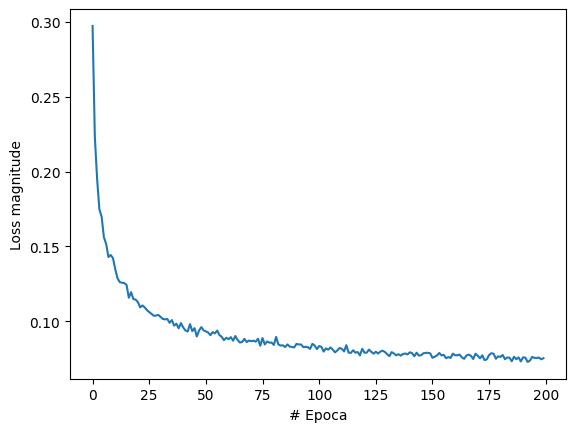

In [20]:
plt.xlabel("# Epoca")
plt.ylabel("Loss magnitude")
plt.plot(history.history["loss"])

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embeddings_input    │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200)       │     40,200 │ embeddings_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200)       │        800 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     12,864 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ km_input            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │         64 │ km_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │      1,552 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         17 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 166,333 (649.74 KB)

 Trainable params: 55,257 (215.85 KB)

 Non-trainable params: 560 (2.19 KB)

 Optimizer params: 110,516 (431.71 KB)

In [22]:
# Escalar los nuevos embeddings
new_embeddings_scaled = scaler_embeddings.transform(np.stack(test_df["embedding"].values))

# Escalar los nuevos 'km'
new_km_scaled = scaler_km.transform(test_df['km'].to_numpy().reshape(-1, 1))

print('Forma de new_embeddings_scaled:', new_embeddings_scaled.shape)
print('Forma de new_km_scaled:', new_km_scaled.shape)

Forma de new_embeddings_scaled: (22079, 200)
Forma de new_km_scaled: (22079, 1)


In [23]:
prediction = model.predict( 
            [
                new_embeddings_scaled, 
                new_km_scaled
            ] 
        ).flatten()

prediction = scaler_y.inverse_transform(prediction.reshape(-1, 1)).flatten()
realPrice = test_df['price'].to_numpy()

print('Forma de prediction:', prediction.shape)

print('Forma de price:', realPrice.shape)

 78/690 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

c:\Users\Barak\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['embeddings_input', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Forma de prediction: (22079,)
Forma de price: (22079,)


In [24]:
result = pd.DataFrame({'Prediction': prediction, 'Real price': realPrice})

diff = np.mean(abs( (realPrice - prediction)/realPrice ))
print(result)
print("Hay un MAPE de " + str(diff) + "%")
plt.show()

         Prediction  Real price
0      44319.460938       46900
1      30736.318359       29999
2      18638.904297       20795
3      24647.294922       24460
4      21515.093750       21900
...             ...         ...
22074  13097.006836       14462
22075  22134.779297       26490
22076  26000.484375       22900
22077  49289.105469       47900
22078  44877.433594       42920

[22079 rows x 2 columns]
Hay un MAPE de 0.1299021047954909%


In [25]:
model.save('models/model_2_text_km_to_price.keras')